In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read data
with open('Datasets/French_En_Small/fr-en-small.txt') as file:
    lines = file.readlines()

french_st, eng_st = [st.split('\t')[0] for st in lines], [st.split('\t')[1] for st in lines]    # [20, len(st)]

french_tks = [st.split() for st in french_st]
eng_tks = [st.split() for st in eng_st]
print('raw tks---')
print(french_tks[:3])
print(eng_tks[:3])

# get vocab of french and eng
french_vocab = sorted(set([tk for tks in french_tks for tk in tks]))
eng_vocab = sorted(set([tk for tks in eng_tks for tk in tks]))

french_itos = {i+3:s for i, s in enumerate(french_vocab)}
french_itos[0] = '<pad>'; french_itos[1] = '<bos>'; french_itos[2] = '<eos>'
french_stoi = {s:i for i, s in french_itos.items()}
french_vocab_size = len(french_itos)

eng_itos = {i+3:s for i, s in enumerate(eng_vocab)}
eng_itos[0] = '<pad>'; eng_itos[1] = '<bos>'; eng_itos[2] = '<eos>'
eng_stoi = {s:i for i, s in eng_itos.items()}
eng_vocab_size = len(eng_itos)
print('vocab ---')
print(french_vocab_size)
print(eng_vocab_size)

new_french_tks = [[french_stoi[tk] for tk in ['<bos>'] + tks + ['<eos>']] for tks in french_tks]
new_eng_tks = [[eng_stoi[tk] for tk in ['<bos>'] + tks + ['<eos>']] for tks in eng_tks]
print('new tks---')
print(new_french_tks[:3])
print(new_eng_tks[:3])

raw tks---
[['elle', 'est', 'vieille', '.'], ['elle', 'est', 'tranquille', '.'], ['elle', 'a', 'tort', '.']]
[['she', 'is', 'old', '.'], ['she', 'is', 'quiet', '.'], ['she', 'is', 'wrong', '.']]
vocab ---
46
38
new tks---
[[1, 20, 24, 45, 4, 2], [1, 20, 24, 42, 4, 2], [1, 20, 5, 40, 4, 2]]
[[1, 30, 21, 25, 4, 2], [1, 30, 21, 27, 4, 2], [1, 30, 21, 37, 4, 2]]


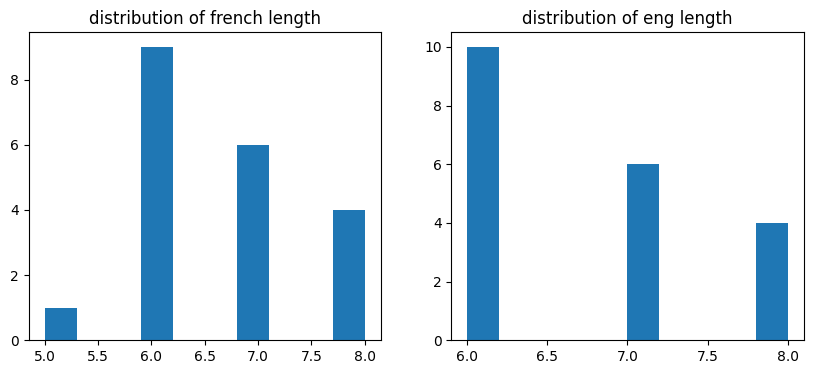

max length 8
torch.Size([20, 8])
torch.Size([20, 8])


In [121]:
# analysis length of data
french_length = [len(line) for line in new_french_tks]
eng_length = [len(line) for line in new_eng_tks]
plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(1, 2, 1); plt.hist(french_length, bins=10); plt.title('distribution of french length')
plt.subplot(1, 2, 2); plt.hist(eng_length, bins=10); plt.title('distribution of eng length')
plt.show()
print(f'max length {max(max(french_length), max(eng_length))}')

# padding data to a fixed length
max_length = max(max(french_length), max(eng_length))
train_X = torch.tensor([tks + [0] * (max_length - len(tks)) for tks in new_french_tks], dtype=torch.long, device="cuda" if torch.cuda.is_available() else "cpu")
train_y = torch.tensor([tks + [0] * (max_length - len(tks)) for tks in new_eng_tks], dtype=torch.long, device="cuda" if torch.cuda.is_available() else "cpu")
print(train_X.shape)
print(train_y.shape)

In [122]:
# encoder: encode french tks to vector
class Encoder(nn.Module):
    def __init__(self, vocab_size, vocab_dims, num_hidden, num_layers, drop_prob=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_dims)
        self.gru = nn.GRU(vocab_dims, num_hidden, num_layers, dropout=drop_prob)
    
    def forward(self, x, state=None):   # (num_steps, batch_size)
        x = self.embedding(x)  # (num_steps, batch_size, vocab_dims)
        return self.gru(x)         # (num_steps, batch_size, num_hidden) , (num_layers, batch_size, num_hidden)

In [123]:
# attention mechanism
class Attention(nn.Module):
    def __init__(self, input_size, attention_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, attention_size, bias=False),
            nn.Tanh(),
            nn.Linear(attention_size, 1,bias=False)
        )
    
    def forward(self, enc_states, dec_state):   # enc_states (num_steps, batch_size, num_hidden), dec_state (batch_size, num_hidden)
        broadcast_dec_state = dec_state.unsqueeze(dim=0).expand_as(enc_states) # (1, batch_size, num_hidden) -> (num_steps, batch_size, num_hidden) like broadcast but do not change data
        enc_and_dec_states = torch.cat([enc_states, broadcast_dec_state], dim=2) # (num_steps, batch_size, num_hidden*2)
        e = self.net(enc_and_dec_states)    # (num_steps, batch_size, 1)
        alpha = F.softmax(e, dim=0) # (num_steps, batch_size, 1)
        return (alpha * enc_states).sum(dim=0)  # (batch_size, num_hidden)

In [124]:
# decoder: decode vector to english
class Decoder(nn.Module):
    def __init__(self, vocab_size, vocab_dims, num_hidden, num_layers, attention_size=10, drop_prob=0): # assert encoder and decoder have same num_hidden
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_dims)
        self.gru = nn.GRU(num_hidden + vocab_dims, num_hidden, num_layers, dropout=drop_prob)     # num_hidden of Encoder + vocab_dims, consider both attention mechanism and inputs
        self.attention = Attention(num_hidden*2, attention_size)
        self.linear = nn.Linear(num_hidden, vocab_size)
    
    def forward(self, cur_input, state_decoder, states_encoder):    # (batch_size, ) , (num_layers, batch_size, num_hidden), (num_steps ,batch_size, num_hidden)
        c = self.attention(states_encoder, state_decoder[-1])   # (batch_size, num_hidden)
        input_c = torch.cat([self.embedding(cur_input), c], dim=1).unsqueeze(dim=0) # (1, batch_size, num_hidden + vocab_dims)
        output, new_state = self.gru(input_c, state_decoder)   # (1, batch_size, num_hidden), (num_layers, batch_size, num_hidden)
        output = self.linear(output).squeeze(dim=0) # (batch_size, vocab_size)
        return output, new_state

# train our model

In [125]:
torch.manual_seed(42)
torch.cuda.empty_cache()

num_epochs, lr, batch_size = 1500, 0.01, 2
embed_size, num_hiddens, num_layers, attention_size, drop_prob = 64, 64, 2, 10, 0.5

device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = Encoder(french_vocab_size, embed_size, num_hiddens, num_layers, drop_prob).to(device)
decoder = Decoder(eng_vocab_size, embed_size, num_hiddens, num_layers, attention_size,drop_prob).to(device)
loss = nn.CrossEntropyLoss(reduction='none').to(device)

optimizer = torch.optim.Adam([
    {'params':encoder.parameters()},
    {'params':decoder.parameters()}
], lr= 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

lossi = []
for epoch in range(num_epochs):
    idx = torch.randint(0, train_X.shape[0], (batch_size, ))
    
    # forward pass
    # french to vector
    X, Y = train_X[idx], train_y[idx]   # (2, 8)    (batch_size, num_steps)
    enc_outputs, enc_states = encoder(X.permute(1, 0))
    
    # vector to eng
    Y = Y.permute(1, 0)     # (8, 2)
    dec_input = Y[0]    # (2)
    dec_state = enc_states  # (2, 2, 64)
    
    l = 0.0
    num_elements = 0    # do not include Y[0]
    for y in Y[1:]: # (2)
        dec_output, dec_state = decoder(dec_input, dec_state, enc_states)   # (batch_size, vocab_size), (num_layers, batch_size, num_hidden)
        mask = [0 if tk == 0 else 1 for tk in dec_input]
        l += (loss(dec_output, y) * torch.tensor(mask).to(device)).sum()
        num_elements += sum(mask)
        
    l /= num_elements
    
    # backward pass
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    scheduler.step()
    
    # track stats1
    lossi.append(l.item())
    if epoch % 100 == 0:
        print(f'epoch {epoch:6d}, loss {l.item() :10f}')
        
print(f'epoch {epoch:6d}, loss {l.item() :10f}') 

epoch      0, loss   3.638365
epoch    100, loss   0.477515
epoch    200, loss   0.375593
epoch    300, loss   0.335726
epoch    400, loss   0.164889
epoch    500, loss   0.141868
epoch    600, loss   0.218432
epoch    700, loss   0.255509
epoch    800, loss   0.341153
epoch    900, loss   0.104504
epoch   1000, loss   0.170653
epoch   1100, loss   0.036617
epoch   1200, loss   0.049300
epoch   1300, loss   0.085276
epoch   1400, loss   0.019912
epoch   1499, loss   0.002562


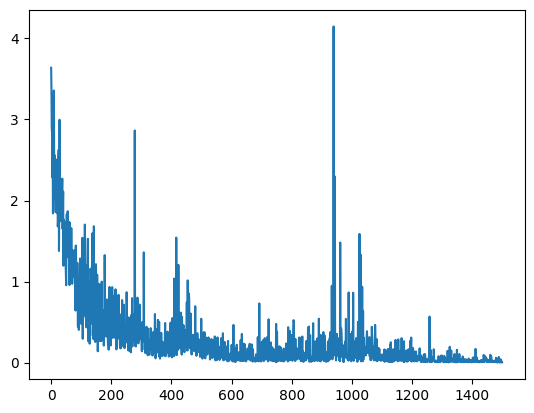

In [126]:
plt.plot(lossi)
plt.show()

In [127]:
torch.save({'encoder': encoder.state_dict(), 'decoder': decoder.state_dict()}, 'Parameters/seq2seq_attention.pt')

# predict

In [131]:
raw_st = 'ils regardent .'
raw_tks = ['<bos>'] + raw_st.split() + ['<eos>'] + ['<pad>'] * (max_length - len(raw_st.split()) - 2)
X = torch.tensor([french_stoi[tk] for tk in raw_tks], dtype=torch.long, device=device).view(-1, 1)  # (num_steps, batch_size) -> (8, 1)
print(raw_tks)

with torch.no_grad():
    outputs = []
    enc_outputs, enc_states = encoder(X)
    dec_input = torch.tensor([eng_stoi['<bos>']], dtype=torch.long, device=device)
    outputs.append(dec_input.item())
    dec_state = enc_states
    
    while 1:
        dec_output, dec_state = decoder(dec_input, dec_state, enc_states)   # (1, vocab_size(38?))
        probs = F.softmax(dec_output, dim=1)
        output = torch.argmax(probs, dim=1)
        print(output)
        outputs.append(output.item())
        
        dec_input = output
        if output == 2:
            break
print(''.join(eng_itos[tk] + ' ' for tk in outputs))

['<bos>', 'ils', 'regardent', '.', '<eos>', '<pad>', '<pad>', '<pad>']
tensor([32], device='cuda:0')
tensor([9], device='cuda:0')
tensor([36], device='cuda:0')
tensor([4], device='cuda:0')
tensor([2], device='cuda:0')
<bos> they are watching . <eos> 
